In [55]:
import sys
import numpy as np
import pandas as pd
import pickle
 
import warnings 
warnings.filterwarnings("ignore")

sys.path.insert(1, "..")
import src.constants as cst
from src.preprocessing import preprocessing as prep
from src.models import prediction_pipeline as pipe
from src.models import gsearch
from src.evaluation import performance_evaluation as perf
from src.interpretability import interpretability as interp
from src.fairness import fairness as fairness

from sklearn.linear_model import LinearRegression, ElasticNet, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from xgboost import XGBClassifier
import interpret.glassbox
from interpret import show

import shap
from pdpbox import pdp

import plotly.express as px

from scipy.stats import chisquare

# Load data

In [4]:
data = pd.read_excel('../data/data_project.xlsx')

# Question 1: Surrogate for unknown models

In [5]:
mask_data_y_hat = (data["y_hat"].notnull())
data_unknown_surrogate = data[mask_data_y_hat]

### Performance of unknown black-box model

In [6]:
y_pred_un = [1 if val > 0.5 else 0 for val in data_unknown_surrogate["y_hat"]]
y_true_un = data_unknown_surrogate["CreditRisk (y)"]
perf.compute_classification_performance_metrics(y_true_un, y_pred_un)

,benchmark,accuracy,precision,recall,F1 score,ROC AUC score
0,0.695,0.85,0.865772,0.928058,0.895833,0.800094


### Surrogate model 1: Ordinal Least Squares

In [7]:
X_train_un_surr, X_test_un_surr, y_train_un_surr, y_test_un_surr = prep.get_train_test(data_unknown_surrogate, cst.unknown_surrogate_model_parameters)
X_train_un_surr, X_test_un_surr = prep.ordinal_encoding(X_train_un_surr, X_test_un_surr, cst.unknown_surrogate_model_parameters)

In [8]:
pipeline_lr = pipe.build_prediction_pipeline(LinearRegression(), cst.unknown_surrogate_model_parameters)
pipeline_lr.fit(X_train_un_surr, y_train_un_surr)

y_hat_pred_lr = pipeline_lr.predict(X_test_un_surr)
y_hat_pred_lr = [1 if val > 1 else 0 if val < 0 else val for val in y_hat_pred_lr]
perf.compute_regression_performance_metrics(y_test_un_surr, y_hat_pred_lr)

,R2 score,RMSE
0,0.268823,0.217437


In [9]:
feature_names = pipeline_lr[:-1].get_feature_names_out()

lr_coefs = pd.DataFrame(
    pipeline_lr.named_steps["estimator"].coef_,
    columns=["Coefficients"],
    index=feature_names,
)

fig = px.bar(lr_coefs.sort_values("Coefficients"), orientation="h", title="Linear regression coefficients")
fig.update_layout(xaxis_title="Coefficient", yaxis_title="Feature", showlegend=False)
fig.show()

### Surrogate model 2: Logistic regression

In [10]:
y_train_un_surr_cl = [1 if val > 0.5 else 0 for val in y_train_un_surr]
y_test_un_surr_cl = [1 if val > 0.5 else 0 for val in y_test_un_surr]

pipeline_log = pipe.build_prediction_pipeline(LogisticRegression(), cst.unknown_surrogate_model_parameters)
pipeline_log.fit(X_train_un_surr, y_train_un_surr_cl)

y_hat_pred_log = pipeline_log.predict(X_test_un_surr)
perf.compute_classification_performance_metrics(y_test_un_surr_cl, y_hat_pred_log)

,benchmark,accuracy,precision,recall,F1 score,ROC AUC score
0,0.794444,0.827778,0.858974,0.937063,0.896321,0.671234


In [11]:
feature_names = pipeline_log[:-1].get_feature_names_out()

log_coefs = pd.DataFrame(
    pipeline_log.named_steps["estimator"].coef_.T,
    columns=["Coefficients"],
    index=feature_names,
)

fig = px.bar(log_coefs.sort_values("Coefficients"), orientation="h", title="Logistic regression coefficients")
fig.update_layout(xaxis_title="Coefficient", yaxis_title="Feature", showlegend=False)
fig.show()

### Surrogate model 3: Decision tree regressor

In [12]:
dtree_pipeline = pipe.build_prediction_pipeline(DecisionTreeRegressor(criterion="squared_error", random_state=100), cst.unknown_surrogate_model_parameters)
dtree_pipeline.fit(X_train_un_surr, y_train_un_surr)
y_hat_pred_dtree = dtree_pipeline.predict(X_test_un_surr)
y_hat_pred_dtree = [1 if val > 1 else 0 if val<0 else val for val in y_hat_pred_dtree]
perf.compute_regression_performance_metrics(y_test_un_surr, y_hat_pred_dtree)

,R2 score,RMSE
0,-0.129074,0.270198


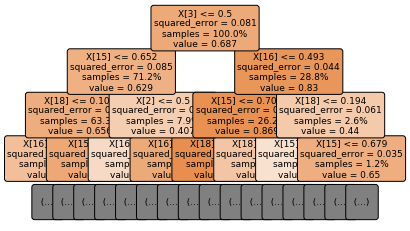

In [13]:
dtree_visualization = plot_tree(dtree_pipeline['estimator'], max_depth=3, fontsize=9, proportion=True, filled=True, rounded=True)

### Surrogate model 4: Decision tree classifier

In [14]:
dtree_cl_pipeline = pipe.build_prediction_pipeline(DecisionTreeClassifier(random_state=100), cst.unknown_surrogate_model_parameters)
dtree_cl_pipeline.fit(X_train_un_surr, y_train_un_surr_cl)
y_hat_pred_dtree = dtree_cl_pipeline.predict(X_test_un_surr)

perf.compute_classification_performance_metrics(y_test_un_surr_cl, y_hat_pred_dtree)

,benchmark,accuracy,precision,recall,F1 score,ROC AUC score
0,0.794444,0.761111,0.852113,0.846154,0.849123,0.639293


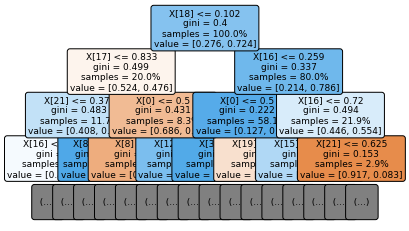

In [15]:
dtree_cl_visualization = plot_tree(dtree_cl_pipeline['estimator'], max_depth=3, fontsize=9, proportion=True, filled=True, rounded=True)

# Question 2: Blackbox model for classification

In [16]:
# Get train test from the data
X_train, X_test, y_train, y_test = prep.get_train_test(data, cst.classification_model_parameters)

In [17]:
# Preprocess the data before applying a model to keep column names for interpretability plots
X_train, X_test = prep.ordinal_encoding(X_train, X_test, cst.classification_model_parameters)
X_train, X_test = prep.one_hot_encoding(X_train, X_test, cst.classification_model_parameters)

In [18]:
# Run a randomized search for a xgboost model using a grid of parameters
best_estimator, best_score = gsearch.randomized_search_from_xgb_classifier(X_train, y_train)

In [19]:
# Evaluate the performance of the model on the test set 
y_test_pred = best_estimator.predict(X_test)
y_test_pred_proba = best_estimator.predict_proba(X_test)[:,1]
perf.compute_classification_performance_metrics(y_test, y_test_pred)

,benchmark,accuracy,precision,recall,F1 score,ROC AUC score
0,0.695,0.871667,0.899061,0.918465,0.90866,0.841746


# Question 3: Global surrogate for the blackbox model

In [20]:
enet = ElasticNet(alpha=.01, l1_ratio=.2)

In [21]:
X_train_bbox, X_test_bbox, y_train_bbox, y_test_bbox = train_test_split(X_test, y_test_pred_proba, train_size=.7, random_state=42)

In [22]:
enet.fit(X_train_bbox, y_train_bbox)
y_test_bbox_pred = enet.predict(X_test_bbox)
perf.compute_regression_performance_metrics(y_test_bbox, y_test_bbox_pred)

,R2 score,RMSE
0,0.201042,0.343623


In [23]:
X_train_bbox, X_test_bbox = prep.min_max_scaling(X_train_bbox, X_test_bbox, cst.unknown_surrogate_model_parameters)

In [24]:
lr_bbox = LinearRegression()
lr_bbox.fit(X_train_bbox, y_train_bbox)
y_pred_bbox_lr = lr_bbox.predict(X_test_bbox)
y_pred_bbox_lr = [1 if val > 1 else 0 if val < 0 else val for val in y_pred_bbox_lr]
perf.compute_regression_performance_metrics(y_test_bbox, y_pred_bbox_lr)

,R2 score,RMSE
0,0.1944,0.345049


In [25]:
lr_bbox_coefs = pd.DataFrame(
    lr_bbox.coef_,
    columns=["Coefficients"],
    index=X_train_bbox.columns,
)

fig = px.bar(lr_bbox_coefs.sort_values("Coefficients"), orientation="h", title="Linear regression coefficients")
fig.update_layout(xaxis_title="Coefficient", yaxis_title="Feature", showlegend=False)
fig.show()

In [26]:
y_train_bbox_cl = [1 if val > 0.5 else 0 for val in y_train_bbox]
y_test_bbox_cl = [1 if val > 0.5 else 0 for val in y_test_bbox]
log_bbox = LogisticRegression()
log_bbox.fit(X_train_bbox, y_train_bbox_cl)
y_pred_bbox_log = log_bbox.predict(X_test_bbox)
perf.compute_classification_performance_metrics(y_test_bbox_cl, y_pred_bbox_log)

,benchmark,accuracy,precision,recall,F1 score,ROC AUC score
0,0.694444,0.716667,0.746667,0.896,0.814545,0.602545


In [27]:
log_bbox_coefs = pd.DataFrame(
    log_bbox.coef_.T,
    columns=["Coefficients"],
    index=X_train_bbox.columns,
)

fig = px.bar(log_bbox_coefs.sort_values("Coefficients"), orientation="h", title="Logistic regression coefficients")
fig.update_layout(xaxis_title="Coefficient", yaxis_title="Feature", showlegend=False)
fig.show()

In [28]:
dtree_reg_bbox = DecisionTreeRegressor(criterion="squared_error", random_state=100)
dtree_reg_bbox.fit(X_train_bbox, y_train_bbox)
y_pred_bbox_dtree_reg = dtree_reg_bbox.predict(X_test_bbox)
y_pred_bbox_dtree_reg = [1 if val > 1 else 0 if val<0 else val for val in y_pred_bbox_dtree_reg]
perf.compute_regression_performance_metrics(y_test_bbox, y_pred_bbox_dtree_reg)

,R2 score,RMSE
0,0.002558,0.383941


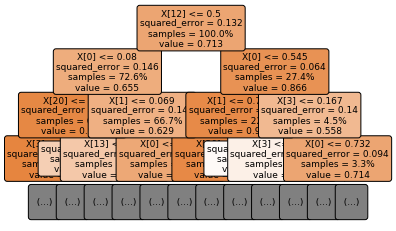

In [29]:
dtree_visualization = plot_tree(dtree_reg_bbox, max_depth=3, fontsize=9, proportion=True, filled=True, rounded=True)

In [30]:
dtree_cl_bbox = DecisionTreeClassifier(random_state=100)
dtree_cl_bbox.fit(X_train_bbox, y_train_bbox_cl)
y_pred_bbox_dtree_cl = dtree_cl_bbox.predict(X_test_bbox)
perf.compute_classification_performance_metrics(y_test_bbox_cl, y_pred_bbox_dtree_cl)

,benchmark,accuracy,precision,recall,F1 score,ROC AUC score
0,0.694444,0.772222,0.862069,0.8,0.829876,0.754545


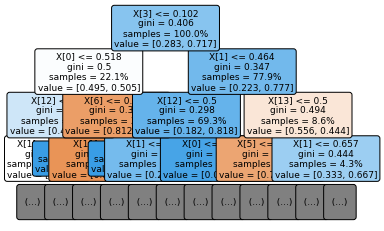

In [31]:
dtree_cl_visualization = plot_tree(dtree_cl_bbox, max_depth=3, fontsize=9, proportion=True, filled=True, rounded=True)

# Question 5: Partial Dependency Plots

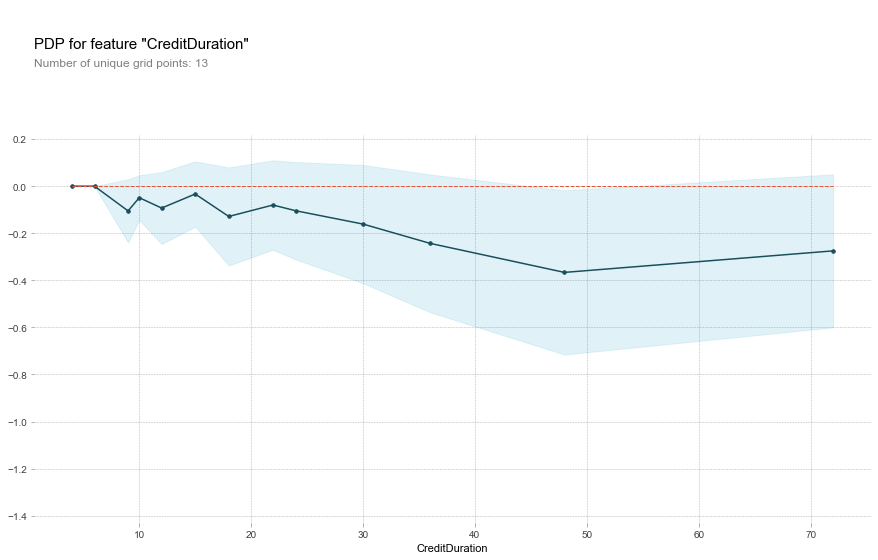

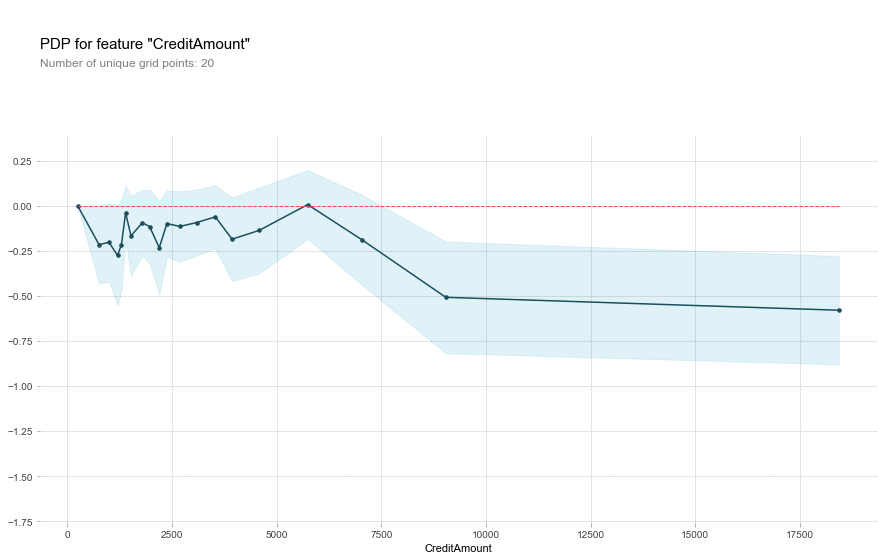

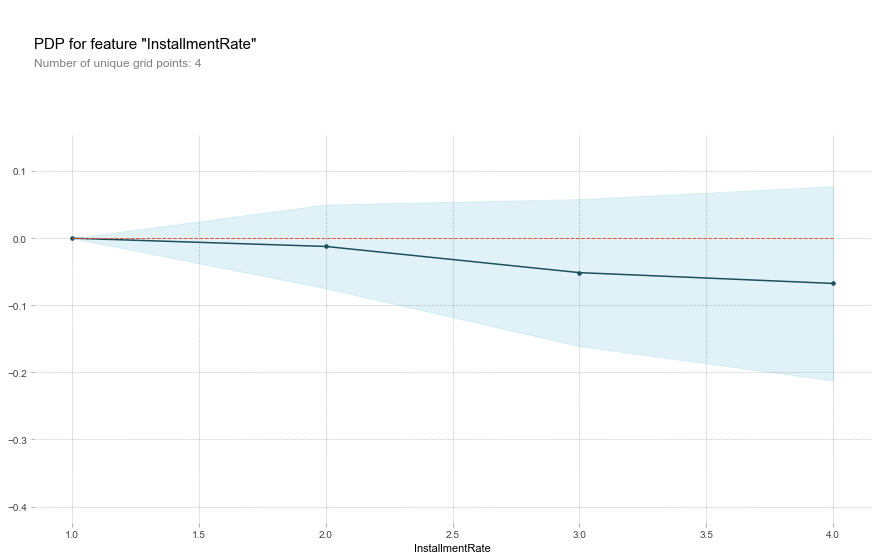

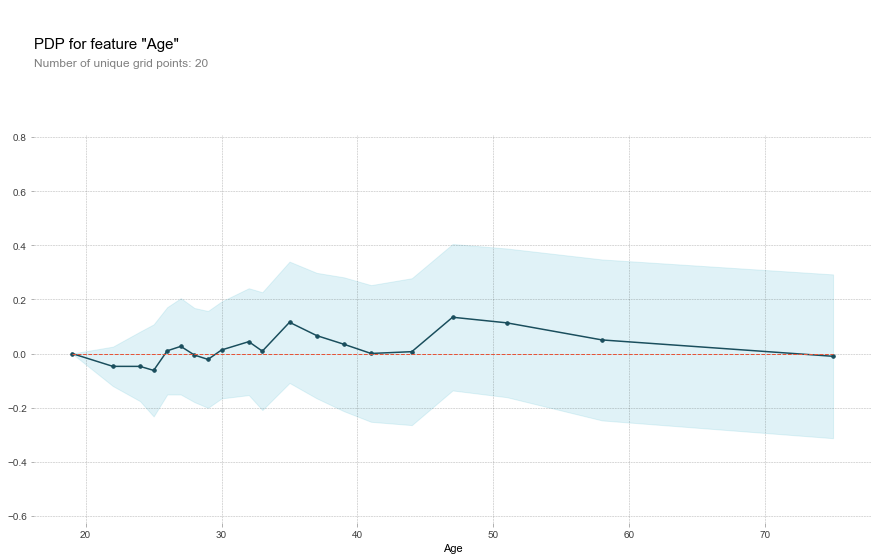

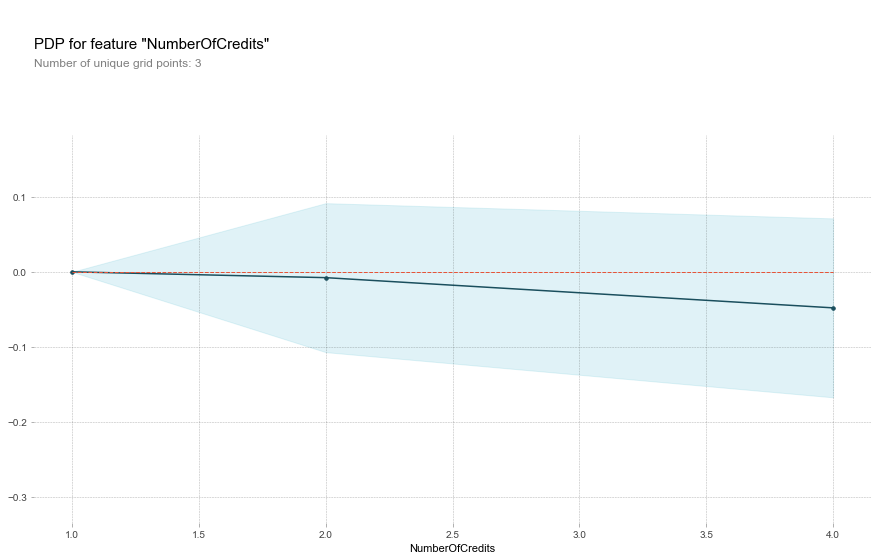

In [32]:
for column in cst.classification_model_parameters["numerical_columns"]:
    interp.plot_univariate_pdp(best_estimator, X_train, column, column)

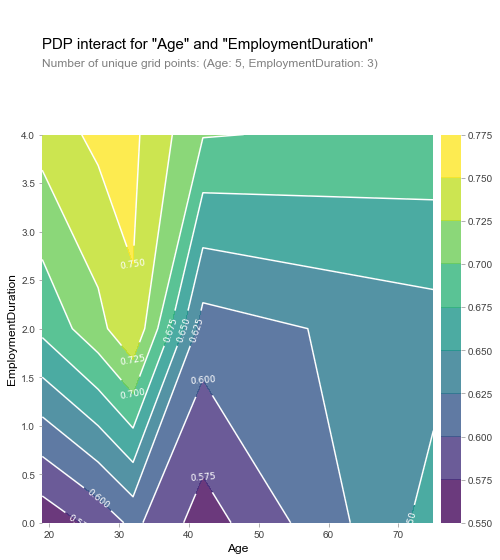

In [33]:
pdp_var = pdp.pdp_interact(
    best_estimator, 
    X_train, 
    X_train.columns, 
    features=['Age', 'EmploymentDuration'], 
    num_grid_points=[5, 5]
)
fig, axes = pdp.pdp_interact_plot(pdp_var, feature_names=['Age', 'EmploymentDuration'])

## Dealing with One Hot Encoded Features

In [ ]:
housing = ['Housing_A151', 'Housing_A152', 'Housing_A153']
purpose = ['Purpose_A40', 'Purpose_A41', 'Purpose_A410', 'Purpose_A42', 'Purpose_A43', 
            'Purpose_A44', 'Purpose_A45', 'Purpose_A46', 'Purpose_A48', 'Purpose_A49']
credit_history = ['CreditHistory_A30', 'CreditHistory_A31', 'CreditHistory_A32',
       'CreditHistory_A33', 'CreditHistory_A34']

onehot_columns = [housing, purpose, credit_history]

In [ ]:
interp.plot_univariate_pdp(best_estimator, X_train, housing, 'Housing')
interp.plot_univariate_pdp(best_estimator, X_train, purpose, 'Profile')
interp.plot_univariate_pdp(best_estimator, X_train, credit_history, 'Credit History')

# Question 6: ALE

PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.


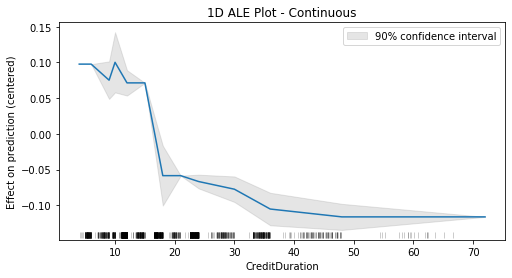

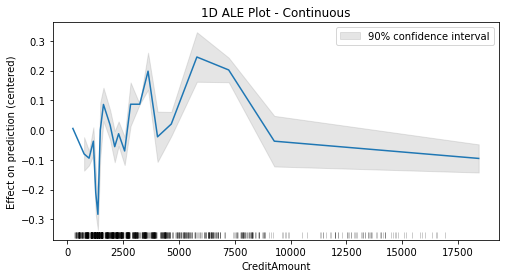

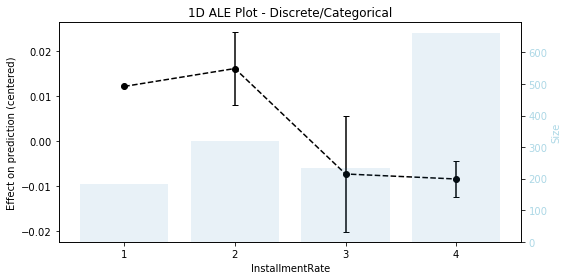

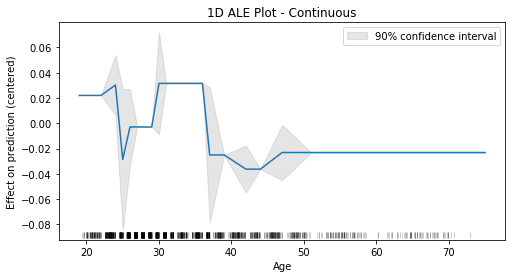

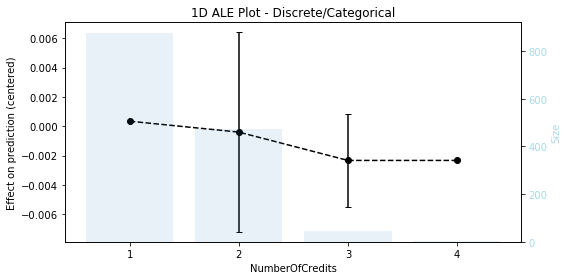

In [34]:
for column in cst.classification_model_parameters["numerical_columns"]:
    interp.plot_ale_effect(best_estimator, X_train, column)

# Question 7: ICE

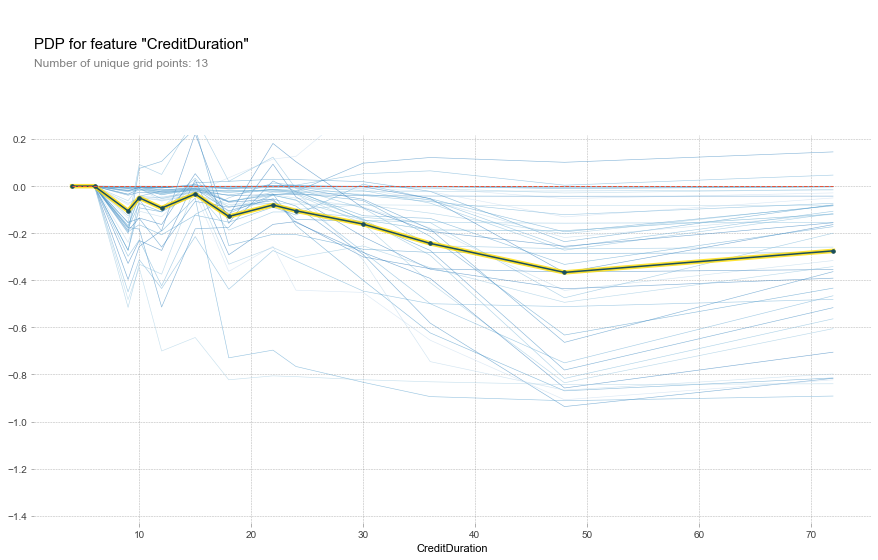

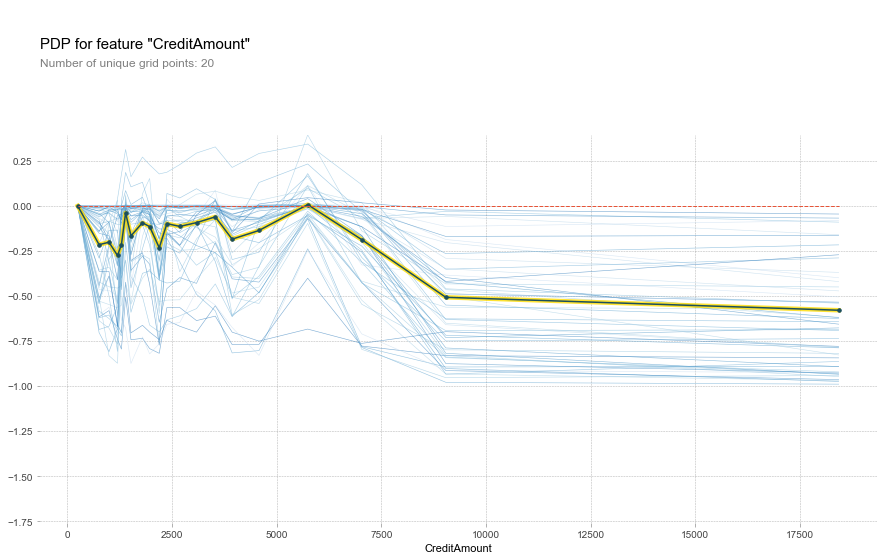

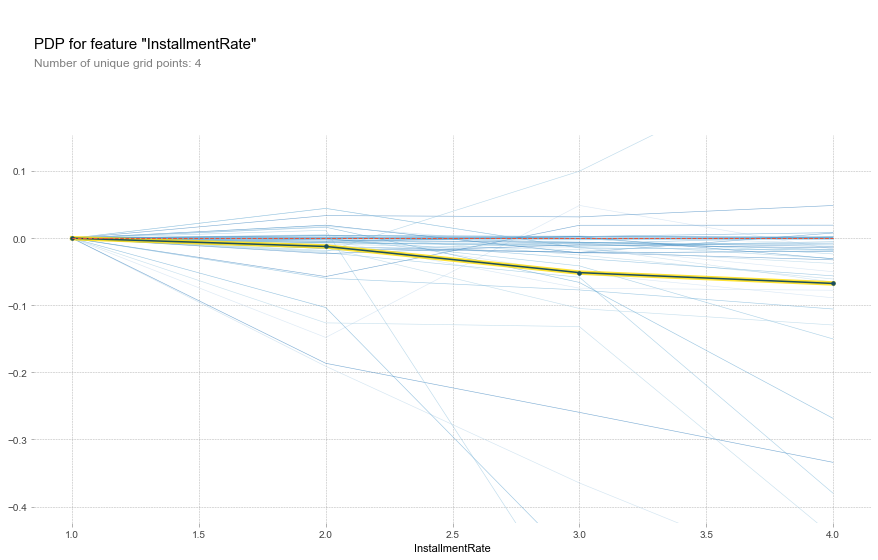

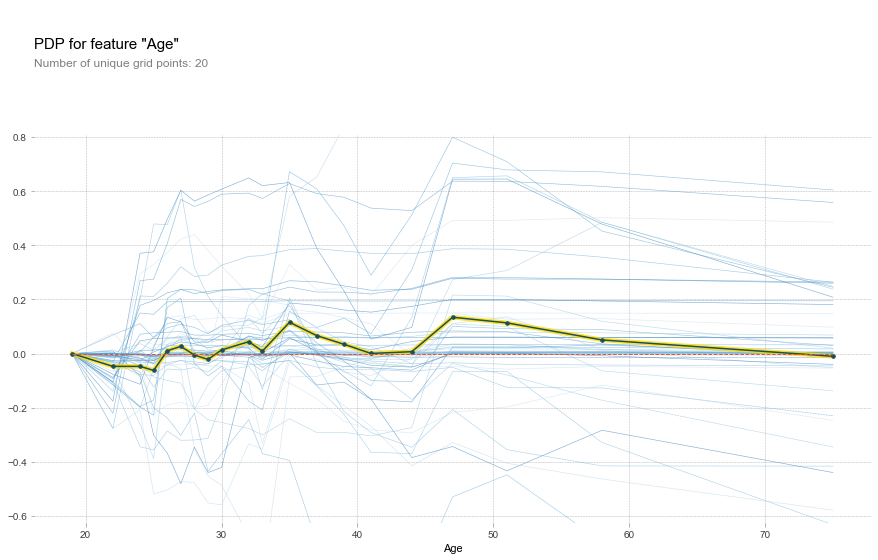

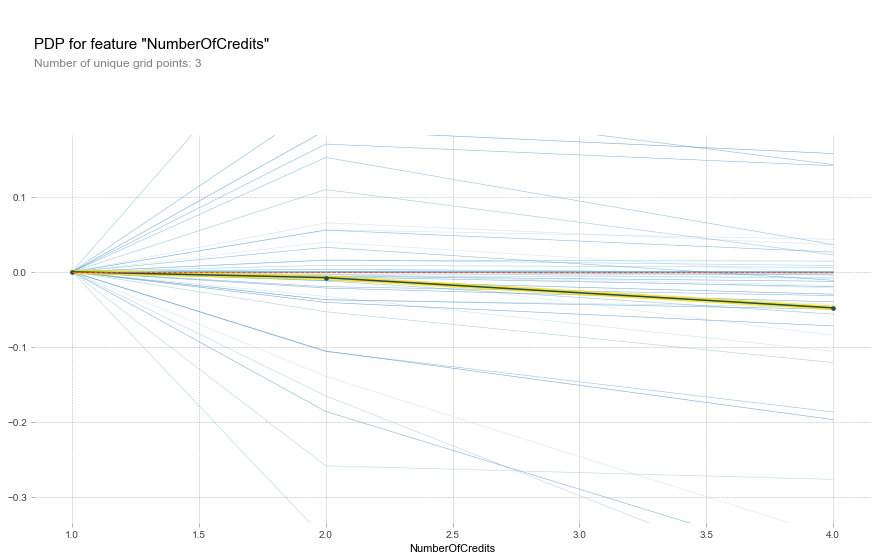

In [35]:
for column in cst.classification_model_parameters["numerical_columns"]:
    interp.plot_ice(best_estimator, X_train, column, 50)

In [ ]:
interp.plot_ice(best_estimator, X_train, credit_history, 50)
interp.plot_ice(best_estimator, X_train, purpose, 50)

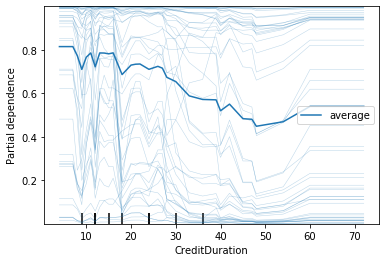

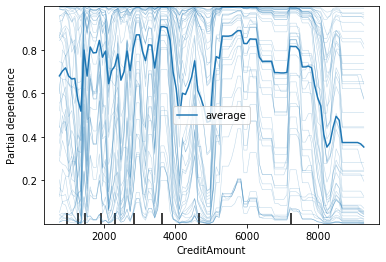

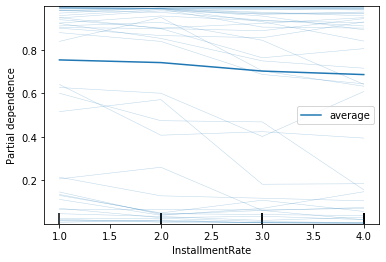

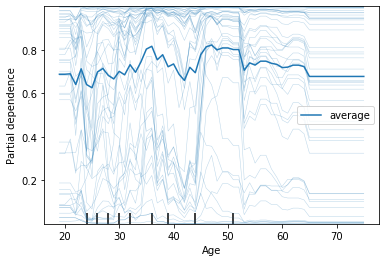

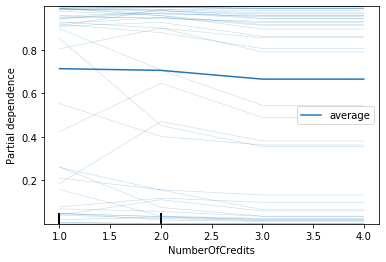

In [36]:
# Using Scikit Learn PartialDependenceDisplay rather than PDPBox
for column in cst.classification_model_parameters["numerical_columns"]:
    interp.pdp_ice_plot_sklearn(best_estimator, X_train, column, 50)

# Question 8 : SHAP

In [37]:
# Explain all the predictions in the test set
explainer = shap.TreeExplainer(best_estimator)
shap_values = explainer.shap_values(X_test)

In [38]:
print(f'Shape: {shap_values.shape}')
pd.DataFrame(shap_values).head(2)

Shape: (600, 24)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.888803,2.831008,0.771583,0.202322,0.139297,0.868575,-0.447899,0.038700,-0.142297,0.118523,...,-0.108430,-0.105532,-0.00194,0.491561,-0.541352,-0.004925,-0.005811,-0.021928,0.0,-0.151996
1,0.682565,1.378650,-0.088446,-0.073690,-0.540143,-0.193089,-0.036705,-0.049928,0.019295,0.109427,...,-0.015285,-0.099353,-0.00155,-0.261322,1.629942,-0.004833,0.000209,-0.016137,0.0,-0.093719


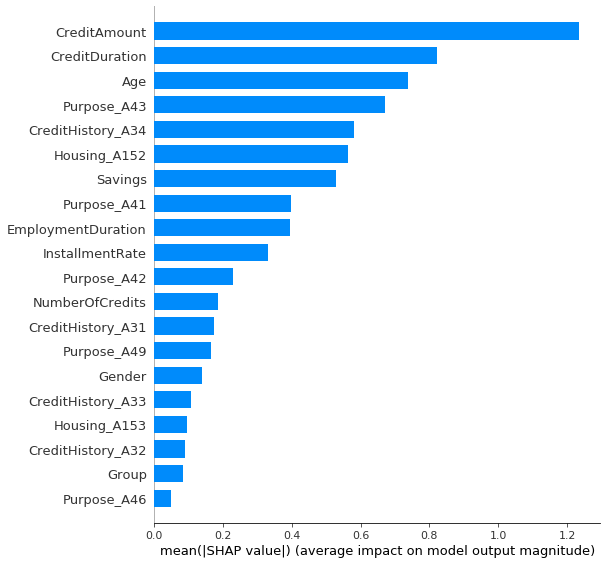

In [39]:
shap.summary_plot(shap_values, X_test,plot_type='bar')

In [40]:
np.round(X_train[["CreditAmount", "CreditDuration", "Age"]].corr(), 2)

,CreditAmount,CreditDuration,Age
CreditAmount,1.00,0.62,0.04
CreditDuration,0.62,1.00,-0.03
Age,0.04,-0.03,1.00


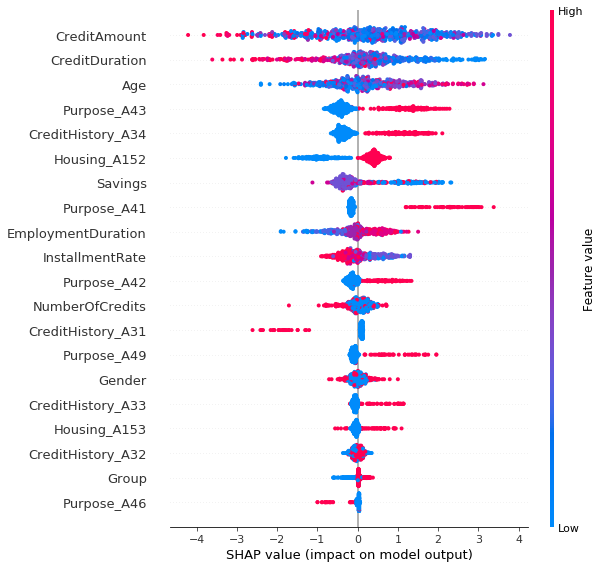

In [41]:
shap.summary_plot(shap_values, X_test)

#### Explain a single feature
To understand the effect a single feature has on the model output, we can plot a SHAP value of that feature vs. the value of the feature for all instances in the dataset.

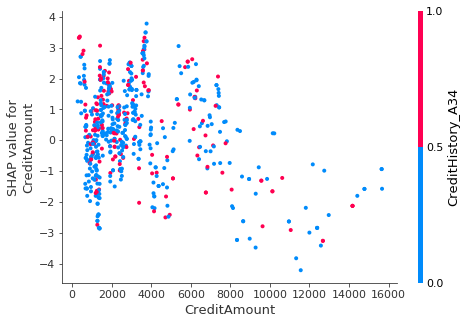

In [42]:
shap.dependence_plot('CreditAmount', shap_values, X_test)

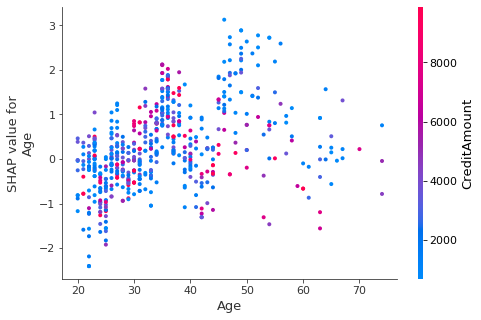

In [43]:
shap.dependence_plot('Age', shap_values, X_test)

With SHAP, we can also generate explanations for a single prediction. The SHAP plot shows features that contribute to pushing the output from the base value (average model output) to the actual predicted value.
Red color indicates features that are pushing the prediction higher, and blue color indicates just the opposite.

In [44]:
shap.initjs()
i = 80
print(best_estimator.predict(X_test.iloc[i:i+1, :])[0])
print(best_estimator.predict_proba(X_test.iloc[i:i+1, :])[0][1])
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i])

0
0.36033124


In [45]:
i = 10
print(best_estimator.predict(X_test.iloc[i:i+1, :])[0])
print(best_estimator.predict_proba(X_test.iloc[i:i+1, :])[0][1])
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i])

1
0.97261465


In [46]:
i = 12
print(best_estimator.predict(X_test.iloc[i:i+1, :])[0])
print(best_estimator.predict_proba(X_test.iloc[i:i+1, :])[0][1])
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i])

0
0.02942388


# Bonus: Explainable Boosting Classifier

In [47]:
# model_ebm = interpret.glassbox.ExplainableBoostingClassifier()
# model_ebm.fit(X_train, y_train)

# save the model to disk
# filename = '../saved_models/ebm_clf_trained.sav'
# pickle.dump(model_ebm, open(filename, 'wb'))

In [48]:
loaded_ebm_model = pickle.load(open("../saved_models/ebm_clf_trained.sav", 'rb'))

In [56]:
ebm_global = loaded_ebm_model.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/140209621209632/ -->

interpret.visual.udash:INFO: Generated mini dash


In [57]:
ebm_local = loaded_ebm_model.explain_local(X_test[5:8], y_test[5:8])
show(ebm_local)

interpret.visual.udash:INFO: Generating mini dash
interpret.visual.udash:INFO: Generated mini dash


<!-- http://127.0.0.1:7001/140210234632416/ -->

interpret.visual.udash:INFO: No overall plot to display: -1|ExplainableBoostingClassifier_1


# Question 9: Fairness

## Statistical Parity

In [58]:
predictions = y_test_pred
true_data = data.loc[X_test.index, :]

In [59]:
fairness.compute_statistical_parity(true_data, predictions)

Computed statistical parity: 1.1463520024190335. p-value: 0.7658979236324437.

## Conditional Statistical Parity

In [60]:
groups = data["Group"].unique()

In [61]:
fairness.compute_conditional_statistical_parity(true_data, predictions, groups)

,statistic,p-value
Male,0.28,0.96
Female,1.93,0.59


## Equalized Odds

In [62]:
credit_risk_vals = data["CreditRisk (y)"].unique()

In [63]:
fairness.compute_equalized_odds(true_data, predictions, credit_risk_vals)

,statistic,p-value
1,0.17,0.98
0,1.75,0.62
